In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# loading the data
reviews_general_selected  = pd.read_csv("C:/Users/Theresa/Downloads/reviews_general_selected.csv")
reviews_additional_selected = pd.read_csv("C:/Users/Theresa/Downloads/reviews_additional_selected.csv")
api_general = pd.read_csv("C:/Users/Theresa/Downloads/api_general.csv")
api_additional = pd.read_csv("C:/Users/Theresa/Downloads/api_additional.csv")
api_basics = pd.read_csv("C:/Users/Theresa/Downloads/api_basics.csv")

In [3]:
# merging the data
reviews = pd.merge(reviews_general_selected, reviews_additional_selected, on='review_id', how='outer')
reviews_full = pd.merge(reviews, api_basics, left_on = "restaurant_id_x", right_on = "id", how = 'left')

In [4]:
# function to calculate the actual date
def calculate_actual_date(row):
    """Berechnet das tatsächliche Datum basierend auf `review_date` und `scraping_date`."""
    review_text = row["review_date"]
    scraping_date = row["scraping_date"]

    # Überprüfen, ob `review_date` ein gültiger String ist
    if not isinstance(review_text, str) or pd.isna(review_text):
        return None

    # Monate
    if "Monat" in review_text:
        months = int(review_text.split()[1]) if "einem" not in review_text else 1
        return scraping_date - relativedelta(months=months)

    # Jahre
    elif "Jahr" in review_text:
        years = int(review_text.split()[1]) if "einem" not in review_text else 1
        return scraping_date - relativedelta(years=years)

    # Wochen
    elif "Woche" in review_text:
        weeks = int(review_text.split()[1]) if "einer" not in review_text else 1
        return scraping_date - pd.to_timedelta(weeks * 7, unit="days")

    # Tage
    elif "Tag" in review_text:
        days = int(review_text.split()[1]) if "einem" not in review_text else 1
        return scraping_date - pd.to_timedelta(days, unit="days")

    # Standardwert, falls nichts passt
    return None

In [5]:
# convert scraping_date to datetime
reviews_full["scraping_date"] = pd.to_datetime(reviews_full["scraping_date"])

# apply the function to the dataframe
reviews_full["actual_review_date"] = reviews_full.apply(calculate_actual_date, axis=1)

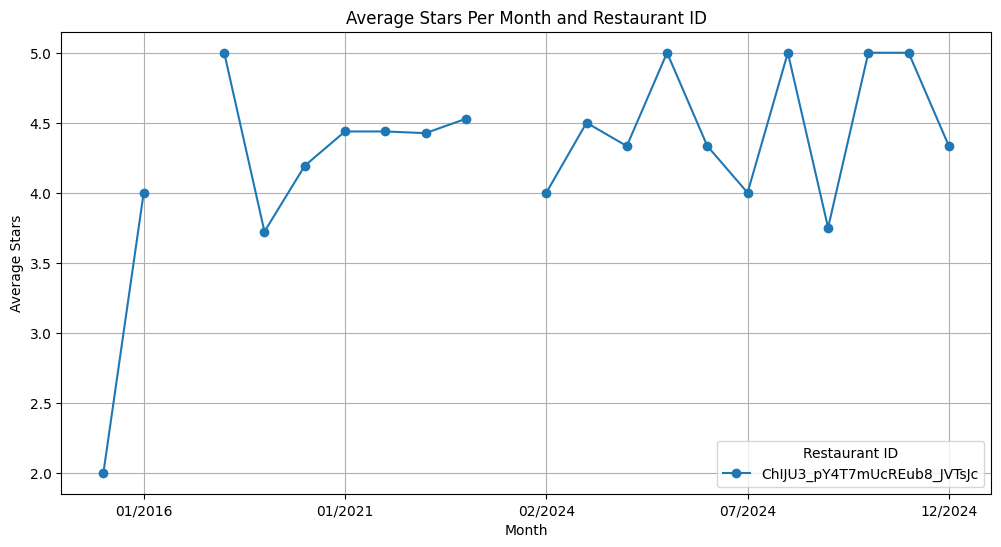

In [6]:
# add column month and year
reviews_full["review_month"] = reviews_full["actual_review_date"].dt.strftime("%m/%Y")

# Group by review_month and restaurant_id, and calculate the average stars
avg_stars_month = reviews_full.groupby(["review_month", "restaurant_id_x"])["stars"].mean().reset_index()

# Pivot the DataFrame for visualization
avg_stars_month_pivot = avg_stars_month.pivot(index="review_month", columns="restaurant_id_x", values="stars")

avg_stars_month_pivot = avg_stars_month_pivot["ChIJU3_pY4T7mUcREub8_JVTsJc"]


plt.figure(figsize=(12, 6))
avg_stars_month_pivot.plot(marker="o", title="Average Stars Per Month and Restaurant ID")
plt.xlabel("Month")
plt.ylabel("Average Stars")
plt.legend(title="Restaurant ID")
plt.grid(True)
plt.show()

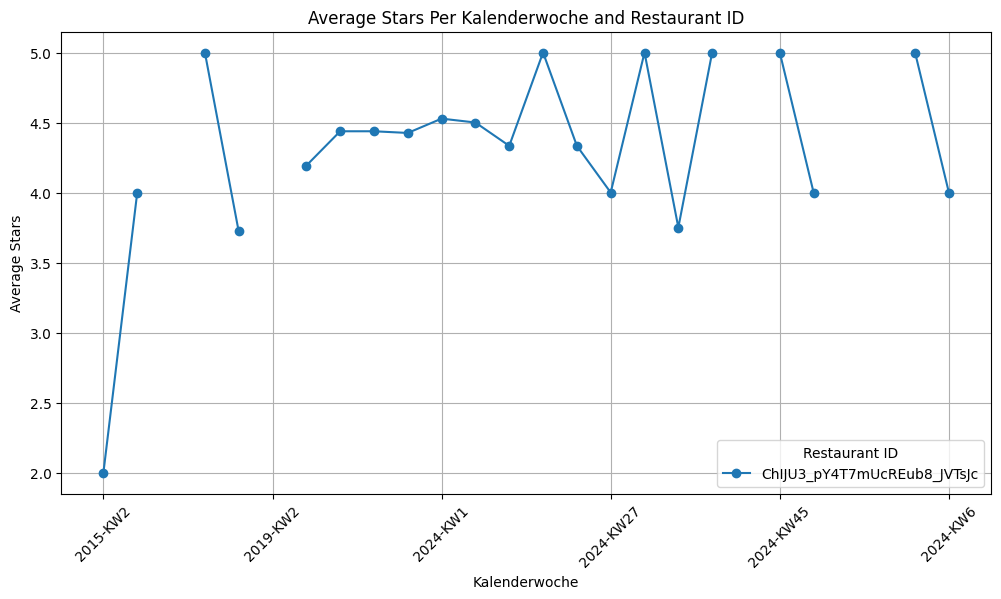

In [7]:
# Add column for review_week in "KW YYYY" format
reviews_full["review_week"] = reviews_full["actual_review_date"].dt.isocalendar().year.astype(str) + "-KW" + reviews_full["actual_review_date"].dt.isocalendar().week.astype(str)

# Group by review_week and restaurant_id, and calculate the average stars
avg_stars_week = reviews_full.groupby(["review_week", "restaurant_id_x"])["stars"].mean().reset_index()

# Pivot the DataFrame for visualization
avg_stars_week_pivot = avg_stars_week.pivot(index="review_week", columns="restaurant_id_x", values="stars")

# Filter for a specific restaurant (optional, change to desired ID)
avg_stars_week_pivot = avg_stars_week_pivot["ChIJU3_pY4T7mUcREub8_JVTsJc"]

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
avg_stars_week_pivot.plot(marker="o", title="Average Stars Per Kalenderwoche and Restaurant ID")
plt.xlabel("Kalenderwoche")
plt.ylabel("Average Stars")
plt.legend(title="Restaurant ID")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



In [13]:
# Gruppiere nach Stadt und Restaurant, und berechne die durchschnittliche Sternebewertung
avg_stars_per_restaurant_per_city = reviews_full.groupby(["city", "restaurant_id_x"])["stars"].mean().reset_index(name="avg_stars")

# Funktion, um die Top 5 Restaurants pro Stadt nach Durchschnitts-Sternebewertung auszuwählen
top_5_restaurants_by_stars_per_city = avg_stars_per_restaurant_per_city.groupby("city").apply(lambda x: x.nlargest(5, "avg_stars")).reset_index(drop=True)

# Anzeigen der Top 5 Restaurants pro Stadt nach Durchschnitts-Sternebewertung
print(top_5_restaurants_by_stars_per_city)

# Optional: Visualisierung der Top 5 Restaurants pro Stadt (nur für eine bestimmte Stadt)
# Beispiel: Top 5 Restaurants in einer bestimmten Stadt visualisieren (z.B. "Tübingen")
city_to_plot = "Tübingen"
top_5_in_city = top_5_restaurants_by_stars_per_city[top_5_restaurants_by_stars_per_city["city"] == city_to_plot]

# Anzeigen der Top 5 Restaurants pro Stadt nach Durchschnitts-Sternebewertung
print(top_5_restaurants_by_stars_per_city)


          city              restaurant_id_x  avg_stars
0     Freiburg  ChIJ1UNVZnURkUcRUxoMXGbQFw8   5.000000
1     Freiburg  ChIJ61nsSAAdkUcRvN29oIFW7oE   5.000000
2     Freiburg  ChIJ85ejdwAdkUcRgLXXE0Ke9Os   5.000000
3     Freiburg  ChIJKzVuNjkRkUcR7Lx_G02KN8M   5.000000
4     Freiburg  ChIJa6ZmnJkbkUcRgQebMXJ4SOk   5.000000
5    Karlsruhe  ChIJ0colKJ0Dl0cR2HQ1SIZuTTY   5.000000
6    Karlsruhe  ChIJ5SJIW0UHl0cR2rI6T5BXDoo   5.000000
7    Karlsruhe  ChIJAQDAi5wFl0cRDR-S2bzTWAw   5.000000
8    Karlsruhe  ChIJAeFjRFYDl0cRy-15WdQOvvQ   5.000000
9    Karlsruhe  ChIJIfZ_LmoFl0cRfPYZkgEM5FU   5.000000
10  Regensburg  ChIJLVN_C7jBn0cRAl_XkxhUaXQ   4.882353
11  Regensburg  ChIJV3_og6PBn0cRBTI3EDLxkc4   4.843750
12  Regensburg  ChIJ4X1Og02Vn0cRLBLJHFpUpk4   4.835616
13  Regensburg  ChIJfZT6Nu7rn0cR85qOlk2fDjo   4.812500
14  Regensburg  ChIJg2mfcczBn0cRNOwGQcOx1VM   4.790850
15    Tübingen  ChIJ3bJ1WPDxmUcRBC55YV0woIA   5.000000
16    Tübingen  ChIJJefnUwD7mUcRw8RE8WokBsc   5.000000
17    Tübi